In [123]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 200)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='darkgrid')
from tqdm import tqdm
from dateutil.relativedelta import relativedelta
import calendar
import torch
from models import MLP, ConvNet, LSTM
from train_test import train, test, output_to_accu, output_to_loss

In [62]:
indice_weight = pd.read_excel('data/Insurances.xlsx', sheet_name='raw_weight', skiprows=[1], index_col=0, parse_dates=True)
indice_weight.drop(columns=indice_weight.columns[0], inplace=True)
indice_weight.index.name = 'Date'
indice_weight = indice_weight.T
indice_weight.index = pd.to_datetime(indice_weight.index, format='%m/%d/%Y')
indice_weight = indice_weight / 100
indice_weight.replace(0, np.nan, inplace=True)
indice_weight.head()

Date        BALN SW Equity  GENN SW Equity  HELN SW Equity  NATN SW Equity  \
2005-12-30          0.0492          0.0022          0.0144          0.0053   
2006-01-31          0.0520          0.0024          0.0151          0.0055   
2006-02-28          0.0502          0.0023          0.0144          0.0053   
2006-03-31          0.0557          0.0027          0.0143          0.0058   
2006-04-28          0.0569          0.0027          0.0163          0.0057   

Date        CHRN SW Equity  SLHN SW Equity  RUKN VX Equity  VAHN SW Equity  \
2005-12-30          0.0232          0.0784          0.3588          0.0015   
2006-01-31          0.0225          0.0771          0.3555          0.0015   
2006-02-28          0.0218          0.0897          0.3282          0.0014   
2006-03-31          0.0243          0.0999          0.3179          0.0015   
2006-04-28          0.0237          0.1048          0.3165          0.0016   

Date        ZURN SW Equity  SREN SW Equity  
2005-12-30          0.4670             NaN  
2006-01-31          0.4683             NaN  
2006-02-28          0.4868             NaN  
2006-03-31          0.4778             NaN  
2006-04-28          0.4718             NaN

In [223]:
prices = pd.read_excel('data/Insurances.xlsx', sheet_name='performance', skiprows=[0,1,2,4,5,6], index_col=0)
daily_returns = prices.pct_change().shift(1).fillna(0)
daily_returns.tail()

BALN SW Equity  GENN SW Equity  HELN SW Equity  NATN SW Equity  \
2021-11-16        0.002736             0.0       -0.000925             0.0   
2021-11-17       -0.004093             0.0       -0.002778             0.0   
2021-11-18       -0.005479             0.0       -0.006500             0.0   
2021-11-19       -0.006887             0.0       -0.010280             0.0   
2021-11-22       -0.010402             0.0       -0.005666             0.0   

            CHRN SW Equity  SLHN SW Equity  RUKN VX Equity  VAHN SW Equity  \
2021-11-16             0.0       -0.002707             0.0        0.000000   
2021-11-17             0.0        0.005041             0.0        0.010188   
2021-11-18             0.0       -0.001543             0.0       -0.006056   
2021-11-19             0.0       -0.005410             0.0       -0.008130   
2021-11-22             0.0       -0.015540             0.0        0.010251   

            ZURN SW Equity  SREN SW Equity  
2021-11-16        0.000995       -0.004261  
2021-11-17        0.000000        0.000225  
2021-11-18        0.000249       -0.000676  
2021-11-19       -0.011180       -0.004507  
2021-11-22       -0.013819       -0.009733

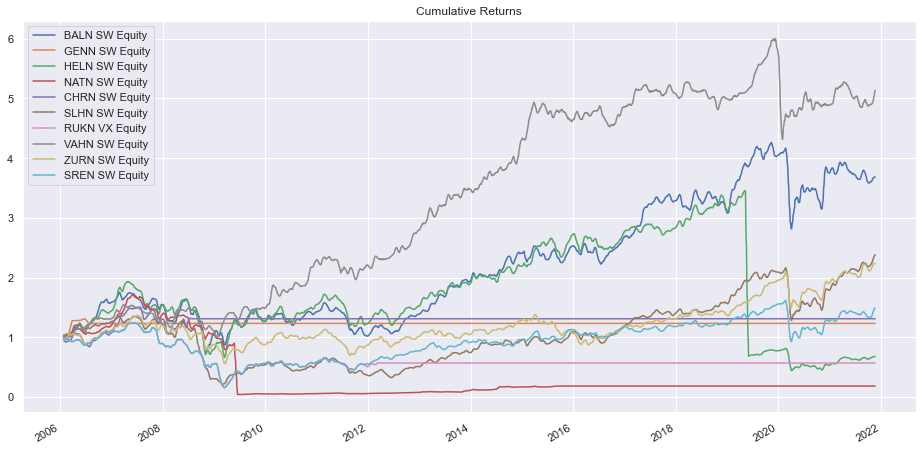

In [224]:
fig, ax = plt.subplots(figsize=(16,8))

(daily_returns + 1).cumprod().rolling(15).mean().plot(ax=ax)
plt.title('Cumulative Returns')
plt.show()

In [225]:
mmonthly_returns = daily_returns.shift(1).resample('M').agg(lambda x: (x + 1).prod() - 1)
max_ret = np.zeros_like(mmonthly_returns.values)
max_ret[np.arange(len(max_ret)), mmonthly_returns.values.argmax(1)] = 1
best_pred = pd.DataFrame(max_ret, columns=mmonthly_returns.columns, index=mmonthly_returns.index).astype(int).shift(-1)
best_pred.head()

BALN SW Equity  GENN SW Equity  HELN SW Equity  NATN SW Equity  \
2006-01-31             0.0             0.0             0.0             0.0   
2006-02-28             0.0             1.0             0.0             0.0   
2006-03-31             0.0             0.0             0.0             0.0   
2006-04-30             0.0             1.0             0.0             0.0   
2006-05-31             0.0             0.0             0.0             0.0   

            CHRN SW Equity  SLHN SW Equity  RUKN VX Equity  VAHN SW Equity  \
2006-01-31             0.0             0.0             0.0             0.0   
2006-02-28             0.0             0.0             0.0             0.0   
2006-03-31             0.0             0.0             0.0             1.0   
2006-04-30             0.0             0.0             0.0             0.0   
2006-05-31             0.0             0.0             0.0             1.0   

            ZURN SW Equity  SREN SW Equity  
2006-01-31             1.0             0.0  
2006-02-28             0.0             0.0  
2006-03-31             0.0             0.0  
2006-04-30             0.0             0.0  
2006-05-31             0.0             0.0

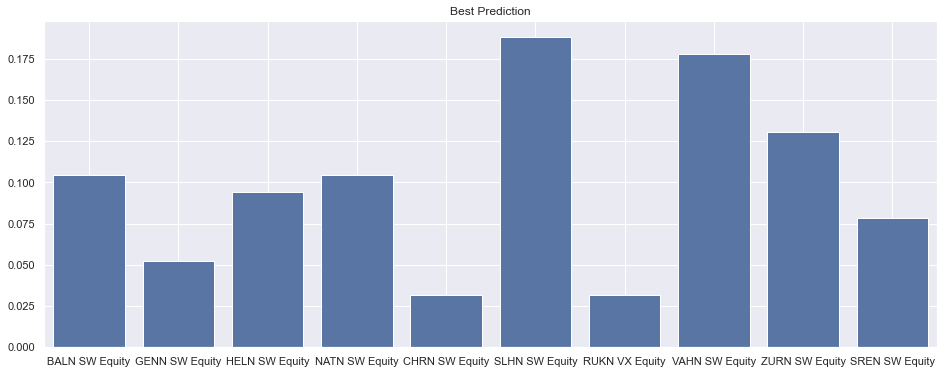

In [226]:
df_results = pd.DataFrame()

df_results = pd.concat([df_results, (best_pred.sum(axis=0) / len(best_pred)).rename('Best_prediction')], axis=1)
df_results = df_results.reset_index()
df_results = df_results.melt(id_vars='index', var_name='strategie', value_name='frequence')

fig, ax = plt.subplots(figsize=(16,6))
sns.barplot(ax=ax, data=df_results, x='index', y='frequence', hue='strategie', zorder=2)
ax.get_legend().remove()
ax.set_xlabel(None)
ax.set_ylabel(None)
plt.grid(b=True)
plt.title('Best Prediction')
plt.show()

In [228]:
all_ratios = pd.read_excel('data/ratio_data.xlsx', sheet_name=None, skiprows=[0,1,2,4,5], parse_dates=True, index_col=0)
all_ratios['comb']
df_X = pd.concat(all_ratios, axis=1)
df_X = df_X.swaplevel(0, 1, 1).sort_index(axis=1).fillna(method='ffill').shift(1).fillna(0)
df_X.head(10)

BALN SW Equity                                                 \
           Cfgrwth_to_INCgrwth  comb    cost incre_oper_marg roc_wacc   vol30   
2006-01-31              0.0000   0.0   0.000          0.0000   0.0000   0.000   
2006-02-28              0.0000   0.0   0.000          0.0000   0.0000  16.617   
2006-03-31              0.0000   0.0   0.000          0.0000   0.0000  15.884   
2006-04-28              0.0000   0.0   0.000          0.0000   0.0000  31.309   
2006-05-31              0.0000   0.0   0.000          0.0000   0.0000  26.176   
2006-06-30              0.0000   0.0   0.000          0.0000   0.0000  27.311   
2006-07-31              5.1602  94.2  27.278        463.8219   0.5543  37.717   
2006-08-31              5.1602  94.2  27.278        463.8219   0.5543  24.633   
2006-09-29              5.1602  94.2  27.278        463.8219   0.5543  15.208   
2006-10-31              5.1602  94.2  27.278        463.8219   0.5543  23.961   

                CHRN SW Equity                                          \
           Cfgrwth_to_INCgrwth      comb cost incre_oper_marg roc_wacc   
2006-01-31              0.0000    0.0000  0.0             0.0   0.0000   
2006-02-28              0.0000    0.0000  0.0             0.0   0.0000   
2006-03-31              0.0000    0.0000  0.0             0.0   0.0000   
2006-04-28              0.0000    0.0000  0.0             0.0  -0.4954   
2006-05-31              0.0000    0.0000  0.0             0.0  -0.4954   
2006-06-30              0.0000    0.0000  0.0             0.0  -0.4954   
2006-07-31             -0.4743  106.8108  0.0             0.0  -0.4658   
2006-08-31             -0.4743  106.8108  0.0             0.0  -0.4658   
2006-09-29             -0.4743  106.8108  0.0             0.0  -0.4658   
2006-10-31             -0.4743  106.8108  0.0             0.0  -0.4658   

                        GENN SW Equity                                     \
             vol30 Cfgrwth_to_INCgrwth comb cost incre_oper_marg roc_wacc   
2006-01-31   0.000                 0.0  0.0  0.0             0.0      0.0   
2006-02-28  27.432                 0.0  0.0  0.0             0.0      0.0   
2006-03-31  19.748                 0.0  0.0  0.0             0.0      0.0   
2006-04-28  32.073                 0.0  0.0  0.0             0.0      0.0   
2006-05-31  22.954                 0.0  0.0  0.0             0.0      0.0   
2006-06-30  41.735                 0.0  0.0  0.0             0.0      0.0   
2006-07-31  59.687                 0.0  0.0  0.0             0.0      0.0   
2006-08-31  33.924                 0.0  0.0  0.0             0.0      0.0   
2006-09-29  20.547                 0.0  0.0  0.0             0.0      0.0   
2006-10-31  22.450                 0.0  0.0  0.0             0.0      0.0   

                        HELN SW Equity                                 \
             vol30 Cfgrwth_to_INCgrwth  comb     cost incre_oper_marg   
2006-01-31   0.000              0.0000   0.0   0.0000             0.0   
2006-02-28  26.095              0.0000   0.0   0.0000             0.0   
2006-03-31  27.792              0.0000   0.0   0.0000             0.0   
2006-04-28  36.368              0.0000   0.0   0.0000             0.0   
2006-05-31   3.429              0.0000   0.0   0.0000             0.0   
2006-06-30   5.512              0.0000   0.0   0.0000             0.0   
2006-07-31  18.927             -0.9894  95.6  30.9017             0.0   
2006-08-31  30.812             -0.9894  95.6  30.9017             0.0   
2006-09-29  30.812             -0.9894  95.6  30.9017             0.0   
2006-10-31  30.812             -0.9894  95.6  30.9017             0.0   

                                 NATN SW Equity                     \
           roc_wacc   vol30 Cfgrwth_to_INCgrwth      comb     cost   
2006-01-31   0.0000   0.000                 0.0    0.0000   0.0000   
2006-02-28   0.0000  25.457                 0.0    0.0000   0.0000   
2006-03-31   0.0000  16.703                 0.0    0.0000   0.0000   
20

In [192]:
def remove_tickers(indice_weight, df_prob):
    
    df = df_prob.copy()
    df_weight = indice_weight.copy().reindex(df.index, method='ffill')
    for index, row in df.iterrows():
        for ticker, value in row.items():   
            if pd.isna(df_weight.at[index, ticker]):
            #if pd.isna(value):
                row.at[ticker] = np.nan
                
    return df

In [141]:
def strategie(df_input_all, best_pred, model_name='MLP', nb_epochs=50, nb_epochs_first=200, input_period=4, training_window=5, batch_size=1, verbose=0, threshold=0.4, eta=1e-3):

    first_end_date = '2011-01-31'

    prob_output = []
    pred_output = []

    all_end_dates = best_pred.loc[first_end_date:].asfreq('6M').index

    for i, end_date in enumerate(tqdm(all_end_dates)):

        start_date = end_date - relativedelta(years=training_window)

        start_date_input = (start_date - relativedelta(months=input_period)) 
        year, month = start_date_input.year, start_date_input.month
        start_date_input = start_date_input.replace(day=calendar.monthrange(year, month)[1])

        df_input = df_input_all.loc[start_date_input:end_date]
        df_output = best_pred.loc[start_date:end_date]

        X = []
        for idx in df_output.index:
            df_input_period = df_input.loc[:idx].iloc[-input_period:]
            X_period = df_input_period.values.reshape(input_period, num_tickers, num_features)
            X.append(X_period)

        X = np.array(X)
        y = df_output.values

        # Find the first prediction date
        if i == 0:
            first_start_date_test = end_date - relativedelta(months=5)

        start_date_test = (end_date - relativedelta(months=5))
        # Make sur the first test date is the end of the month
        year_test, month_test = start_date_test.year, start_date_test.month
        start_date_test = start_date_test.replace(day=calendar.monthrange(year_test, month_test)[1])
        split_index = df_output.index.get_loc(start_date_test)     

        # Create train and test set
        X_train, y_train = X[:split_index], y[:split_index]
        X_test, y_test = X[split_index:], y[split_index:]

        # Transform Numpy arrays to Torch tensors
        X_train, y_train, X_test, y_test = torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float(), torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float()

        # Standardize data within each feature 
        train_mean = X_train.mean(dim=[0, 1, 2], keepdim=True)
        train_std = X_train.std(dim=[0, 1, 2], keepdim=True)
        X_train = X_train.sub_(train_mean).div_(train_std)

        test_mean = X_test.mean(dim=[0, 1, 2], keepdim=True)
        test_std = X_test.std(dim=[0, 1, 2], keepdim=True)
        X_test = X_test.sub_(test_mean).div_(test_std)

        # Allocate the tensors to the GPU, if there is one
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        X_train = X_train.to(device)
        X_test = X_test.to(device)
        y_train = y_train.to(device)
        y_test = y_test.to(device)

        # Initialize ML models only at first iteration
        dim1, dim2, dim3 = X_train.size(1), X_train.size(2), X_train.size(3)
        if i == 0:
            if model_name == 'MLP':
                model = MLP(dim1, dim2, dim3)
            elif model_name == 'ConvNet':
                model = ConvNet(dim1, dim2, dim3)
            elif model_name == 'LSTM':
                model = LSTM(input_size=num_tickers * num_features, output_size=num_tickers)
        model.to(device)

        # More epochs needed for the first iteration 
        if i == 0:
            nb_epochs_all = nb_epochs_first
        else:
            nb_epochs_all = nb_epochs
        # Train the model
        train(model, X_train, y_train, nb_epochs_all, X_test, y_test, i, eta=eta, batch_size=batch_size, verbose=verbose)

        # Get predictions
        prob, _ = test(model, X_test, y_test, threshold=0.4)

        prob_output.append(prob)

    prob_output = np.array(prob_output).reshape(len(all_end_dates) * X_test.size(0), y_test.size(1))
    df_prob = pd.DataFrame(index=best_pred[first_start_date_test:end_date].index, data=prob_output, columns=best_pred.columns)

    return df_prob

  0%|          | 0/22 [00:00<?, ?it/s]

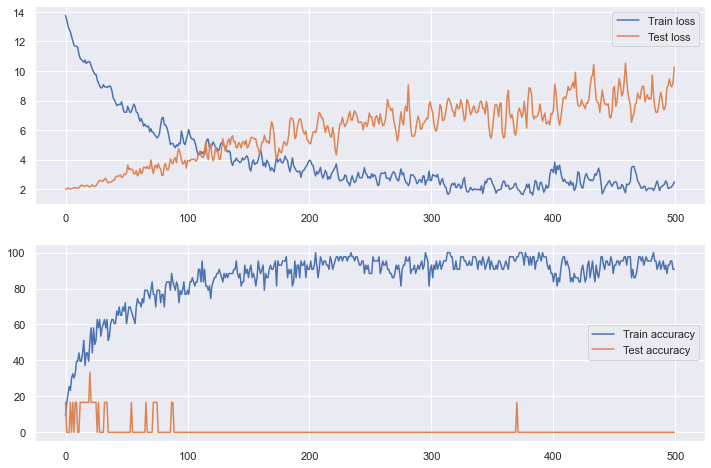

  5%|▍         | 1/22 [00:09<03:27,  9.89s/it]

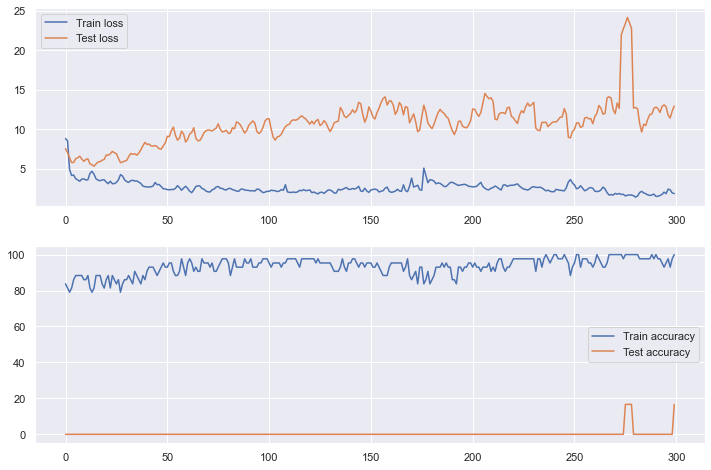

  9%|▉         | 2/22 [00:16<02:56,  8.80s/it]

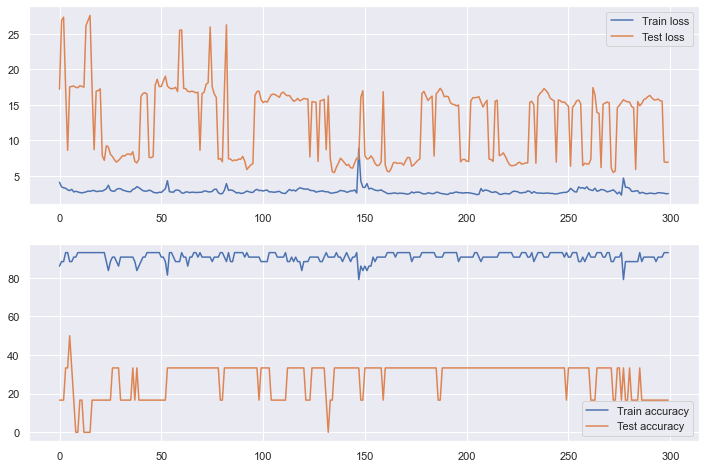

 27%|██▋       | 6/22 [00:41<01:51,  6.97s/it]


KeyboardInterrupt: 

In [260]:
# models_list = ['MLP', 'ConvNet', 'LSTM']
models_list = ['MLP', 'ConvNet']
#models_list = ['MLP']
#df_pred_dict = {}
df_prob_dict = {}

threshold = 0.5
batch_size = 5
verbose = 1
training_window = 4
nb_epochs_first = 500
nb_epochs = 300
eta = 5e-3
input_period = 4

for i, model_name in enumerate(models_list):
    df_prob_dict[model_name] = strategie(df_input_all=df_X, best_pred=best_pred, 
                                                                   model_name=model_name, nb_epochs=nb_epochs, 
                                                                   nb_epochs_first=nb_epochs_first, input_period=input_period, 
                                                                   batch_size=batch_size, verbose=verbose, 
                                                                   training_window=training_window, threshold=threshold, eta=eta)
    
    if i == 0:
        df_prob_dict['Ensemble'] = df_prob_dict[model_name].copy()
    else:
        df_prob_dict['Ensemble'] += df_prob_dict[model_name]
        
df_prob_dict['Ensemble'] /= len(models_list)

In [256]:
n = 2
weight = 0.1

results = remove_tickers(indice_weight, df_prob_dict['MLP'])
df_signal = pd.DataFrame().reindex_like(results)
for index, row in results.iterrows():
    all_tickers = list(row.index)
    largest_tickers = list(row.nlargest(n).index)
    smallest_tickers = list(row.nsmallest(n).index)
    other_tickers = list(set(all_tickers).difference(largest_tickers + smallest_tickers))
    df_signal.at[index, largest_tickers] = 1
    df_signal.at[index, smallest_tickers] = - 1
    df_signal.at[index, other_tickers] = 0.
    #df_signal = df_signal * weight
df_signal = remove_tickers(indice_weight, df_signal) * weight
indice_weight = indice_weight.reindex(df_prob_dict[model_name].index, method='ffill')
portfolio = indice_weight + df_signal
daily_returns_backtest = daily_returns.loc[portfolio.index[0]:portfolio.index[-1]]
perf = (portfolio.reindex(daily_returns_backtest.index, method='ffill').mul(daily_returns_backtest).sum(axis=1) + 1).cumprod()

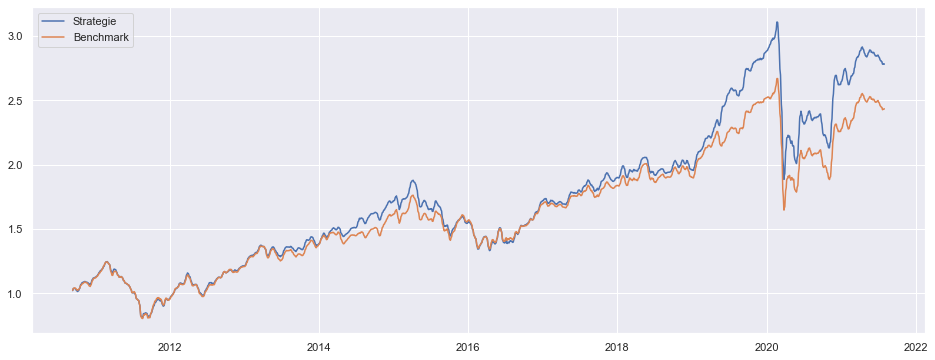

In [257]:
bench_perf = (indice_weight.reindex(daily_returns_backtest.index, method='ffill').mul(daily_returns_backtest).sum(axis=1) + 1).cumprod()
data_plot = pd.concat([perf, bench_perf], axis=1)
data_plot.columns = ['Strategie', 'Benchmark']

fig, ax = plt.subplots(figsize=(16,6))
sns.lineplot(data=data_plot.rolling(10).mean(), dashes=False)
plt.show()

  0%|          | 0/22 [00:00<?, ?it/s]

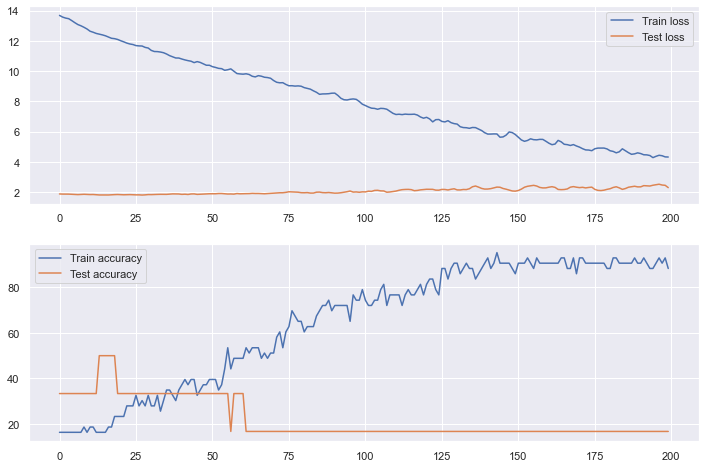

  5%|▍         | 1/22 [00:03<01:20,  3.81s/it]

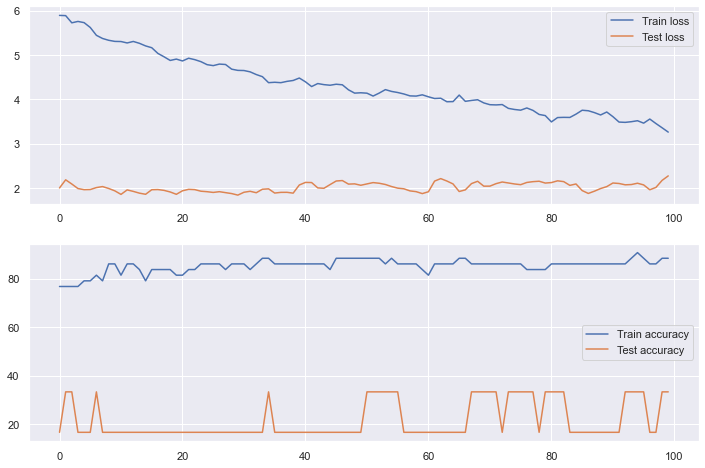

  9%|▉         | 2/22 [00:05<01:05,  3.29s/it]

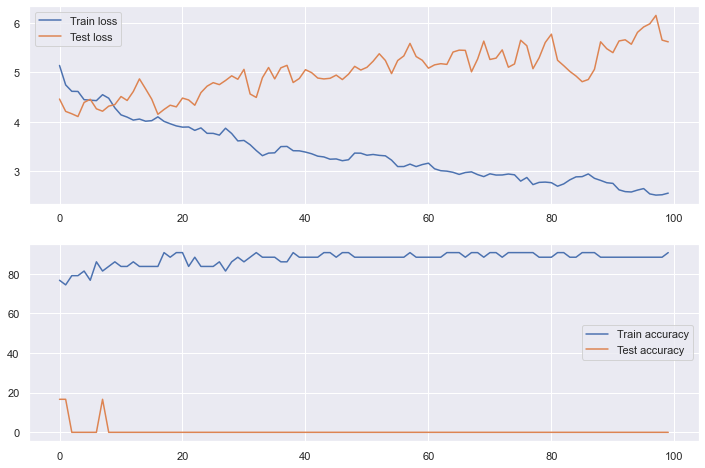

100%|██████████| 22/22 [00:44<00:00,  2.01s/it]


BALN SW Equity  GENN SW Equity  HELN SW Equity  NATN SW Equity  \
2010-08-31    2.328350e-09    4.409086e-06    1.673288e-02    7.437490e-01   
2010-09-30    6.533489e-04    3.533094e-03    3.795381e-01    4.256762e-01   
2010-10-31    1.173156e-02    2.498391e-01    1.348757e-02    4.055907e-02   
2010-11-30    1.064110e-01    8.683634e-02    9.365752e-02    6.259037e-02   
2010-12-31    9.461103e-03    1.482192e-01    1.381363e-01    3.325643e-01   
2011-01-31    2.975330e-03    4.479923e-01    1.072339e-02    4.642162e-02   
2011-02-28    3.123504e-03    1.489061e-02    2.759081e-02    1.137414e-01   
2011-03-31    3.211211e-02    2.676829e-05    7.491532e-01    4.321025e-04   
2011-04-30    1.040627e-01    5.431791e-05    5.231720e-01    4.271512e-03   
2011-05-31    7.693072e-03    1.719353e-02    1.195902e-01    2.202495e-01   
2011-06-30    1.741377e-01    2.266625e-02    2.242778e-01    4.522819e-02   
2011-07-31    1.618063e-02    6.259415e-04    7.760327e-01    2.061710e-02   
2011-08-31    7.832235e-04    1.399090e-03    7.554816e-01    5.272640e-02   
2011-09-30    1.185126e-11    3.251451e-07    1.250186e-02    8.820469e-01   
2011-10-31    3.866422e-13    2.948485e-07    1.786944e-03    9.372146e-01   
2011-11-30    2.528216e-10    9.775779e-07    1.810623e-02    7.967224e-01   
2011-12-31    1.603457e-02    4.628920e-02    1.087251e-02    3.216612e-02   
2012-01-31    2.892253e-03    2.151231e-02    3.198921e-03    2.138370e-02   
2012-02-29    2.426607e-01    3.952815e-02    1.774635e-01    3.584858e-02   
2012-03-31    1.013897e-01    5.493668e-02    6.571209e-02    5.838729e-02   
2012-04-30    1.009860e-01    1.183550e-01    8.574420e-02    7.384463e-02   
2012-05-31    6.053993e-02    1.156329e-01    6.468026e-02    8.767951e-02   
2012-06-30    2.807177e-03    1.461725e-01    1.799708e-01    2.502616e-01   
2012-07-31    2.971893e-04    6.799569e-02    1.091065e-01    4.404722e-01   
2012-08-31    1.429978e-04    8.881360e-04    1.234660e-01    1.810845e-01   
2012-09-30    4.551000e-03    8.483899e-03    2.427628e-01    1.074150e-01   
2012-10-31    8.961538e-03    1.673450e-02    8.311629e-02    9.035559e-02   
2012-11-30    1.686416e-02    2.606913e-02    7.291488e-02    7.049344e-02   
2012-12-31    3.781017e-03    1.628869e-02    8.233125e-02    9.222849e-02   
2013-01-31    1.931302e-03    1.983862e-02    7.884080e-02    2.139764e-01   
2013-02-28    6.246296e-04    6.120020e-03    7.053013e-02    1.023908e-01   
2013-03-31    1.784002e-03    1.222132e-02    6.491249e-02    7.977694e-02   
2013-04-30    1.438946e-02    3.313869e-02    5.696095e-02    7.449399e-02   
2013-05-31    1.026733e-03    1.103715e-02    7.246967e-02    9.209482e-02   
2013-06-30    5.491117e-04    9.044653e-03    8.025198e-02    1.093304e-01   
2013-07-31    2.371961e-03    1.260748e-02    6.721658e-02    8.221105e-02   
2013-08-31    5.987835e-02    1.572045e-02    6.951060e-02    7.315228e-02   
2013-09-30    9.961465e-02    1.828469e-02    7.103636e-02    6.356101e-02   
2013-10-31    1.997525e-01    2.098502e-02    6.878833e-02    4.614584e-02   
2013-11-30    2.366070e-01    2.591670e-02    6.185204e-02    3.832163e-02   
2013-12-31    1.225033e-01    1.377371e-02    8.902857e-02    5.941373e-02   
2014-01-31    8.301953e-03    8.584726e-05    8.523040e-01    3.680796e-03   
2014-02-28    1.856753e-02    6.516502e-03    6.048007e-02    1.214095e-01   
2014-03-31    5.145470e-03    3.166743e-03    5.209379e-02    1.354210e-01   
2014-04-30    1.304741e-02    3.462812e-03    6.156979e-02    1.145172e-01   
2014-05-31    1.962939e-03    6.507669e-04    6.038314e-02    2.986794e-01   
2014-06-30    6.380323e-05    1.718548e-05    6.327186e-04    2.313667e-02   
2014-07-31    9.763153e-05    1.146840e-05    1.103393e-02    4.948740e-03   
2014-08-31    8.513603e-03    2.645500e-03    4.820937e-02    1.452453e-01   
2014-09-30    4.218902e-02    2.466294e-02    5.485424e-02    2.166591e-01   
2014-10-31    6.067656e-01    1.44

In [137]:
df_input_all = df_X
input_period = 6
training_window = 4
num_tickers = len(df_input_all.columns.get_level_values(0).unique())
num_features = len(df_input_all.columns.get_level_values(1).unique())
model_name = 'MLP'
nb_epochs_first = 200
nb_epochs = 100
eta = 1e-3
batch_size = 5
verbose = 1

first_end_date = '2011-01-31'

prob_output = []
pred_output = []

all_end_dates = best_pred.loc[first_end_date:].asfreq('6M').index

for i, end_date in enumerate(tqdm(all_end_dates)):

    start_date = end_date - relativedelta(years=training_window)

    start_date_input = (start_date - relativedelta(months=input_period)) 
    year, month = start_date_input.year, start_date_input.month
    start_date_input = start_date_input.replace(day=calendar.monthrange(year, month)[1])
    
    df_input = df_input_all.loc[start_date_input:end_date]
    df_output = best_pred.loc[start_date:end_date]

    X = []
    for idx in df_output.index:
        df_input_period = df_input.loc[:idx].iloc[-input_period:]
        X_period = df_input_period.values.reshape(input_period, num_tickers, num_features)
        X.append(X_period)

    X = np.array(X)
    y = df_output.values

    # Find the first prediction date
    if i == 0:
        first_start_date_test = end_date - relativedelta(months=5)

    start_date_test = (end_date - relativedelta(months=5))
    # Make sur the first test date is the end of the month
    year_test, month_test = start_date_test.year, start_date_test.month
    start_date_test = start_date_test.replace(day=calendar.monthrange(year_test, month_test)[1])
    split_index = df_output.index.get_loc(start_date_test)     

    # Create train and test set
    X_train, y_train = X[:split_index], y[:split_index]
    X_test, y_test = X[split_index:], y[split_index:]

    # Transform Numpy arrays to Torch tensors
    X_train, y_train, X_test, y_test = torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float(), torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float()

    # Standardize data within each feature 
    train_mean = X_train.mean(dim=[0, 1, 2], keepdim=True)
    train_std = X_train.std(dim=[0, 1, 2], keepdim=True)
    X_train = X_train.sub_(train_mean).div_(train_std)

    test_mean = X_test.mean(dim=[0, 1, 2], keepdim=True)
    test_std = X_test.std(dim=[0, 1, 2], keepdim=True)
    X_test = X_test.sub_(test_mean).div_(test_std)

    # Allocate the tensors to the GPU, if there is one
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    X_train = X_train.to(device)
    X_test = X_test.to(device)
    y_train = y_train.to(device)
    y_test = y_test.to(device)

    # Initialize ML models only at first iteration
    dim1, dim2, dim3 = X_train.size(1), X_train.size(2), X_train.size(3)
    if i == 0:
        if model_name == 'MLP':
            model = MLP(dim1, dim2, dim3)
        elif model_name == 'ConvNet':
            model = ConvNet(dim1, dim2, dim3)
        elif model_name == 'LSTM':
            model = LSTM(input_size=num_tickers * num_features, output_size=num_tickers)
    model.to(device)

    # More epochs needed for the first iteration 
    if i == 0:
        nb_epochs_all = nb_epochs_first
    else:
        nb_epochs_all = nb_epochs
    # Train the model
    train(model, X_train, y_train, nb_epochs_all, X_test, y_test, i, eta=eta, batch_size=batch_size, verbose=verbose)

    # Get predictions
    prob, _ = test(model, X_test, y_test, threshold=0.4)

    prob_output.append(prob)

prob_output = np.array(prob_output).reshape(len(all_end_dates) * X_test.size(0), y_test.size(1))
df_prob = pd.DataFrame(index=best_pred[first_start_date_test:end_date].index, data=prob_output, columns=best_pred.columns)

df_prob